# 1) Sine function generation
In this first draft, we will try to generate sine values from our generator

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

## 1) Preparing the data
In this first part, we'll generate a dataset we can use to train our networks. It will consist in 1024 tuples, representing a sine function. These data are easy to create as we know a formula to generate an infinite amount of them.

Firstly, we'll set a hardcoded seed to be able to reproduce our experience easily

In [20]:
# Use a fixed seed to run similar experiments throughout the tests
torch.manual_seed(111)

In [3]:
# DataSet of size 1024
train_data_length = 1024

In [4]:
train_data = torch.zeros((train_data_length, 2))  # Create a 1024x2 matrix
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)  # Constraint the first values between 0 and 2*PI
train_data[:, 1] = torch.sin(train_data[:, 0])  # Set the second value to the sine of the first value
train_labels = torch.zeros(train_data_length)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

Here we can plot the data we have using matplotlib.

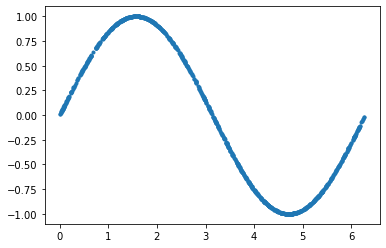

In [5]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

The following bit creates random sample of 32 elements, used to train the discriminator

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## The discriminator
The follwing class implements the discriminator part of our project. It consists in a sequential neural network.
![DiscriminatorDiagram](../Diagrams/SineTest/SineDiscriminator.png)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
discriminator = Discriminator()

## 3) The Generator
Now we will implement the central piece of our GAN, the Generator. It is also a sequential Network, but with diffrences in its architecture
![DiscriminatorDiagram](../Diagrams/SineTest/SineGenerator.png)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
generator = Generator()

## 4) Training

#### Training Parameters
To train our networks, we'll need to set some values.

* lr (Learning Rate):

This value represents the weight of the modification to apply during the backpropagation. The higher this rate is, the more the weights of the neurons will be changed. 

* epochs:

The number of training iterations

* Loss Function:

The function used to compute the error rate of the network in order to update the weights of the neurons.

In [11]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

#### Pytorch Optimizator
The next lines set an optimizer to be used during gradient calculations. We'll use the Adam optimizer, derivated from the "Adaptive Moment Optimizer".

In [12]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

#### 

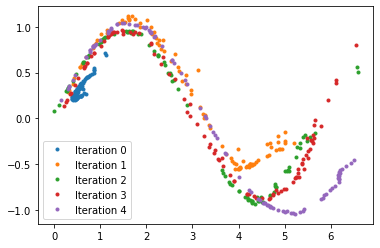

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 100 == 0 and n == batch_size - 1:
            latent_space_samples = torch.randn(100, 2)
            generated_samples = generator(latent_space_samples)
            generated_samples = generated_samples.detach()
            plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
    plt.legend([f'Iteration {x}' for x in range(5)])

## 5) Results
Now we will try to see if the generator has trained correctly by making him generate data, and showing it

In [18]:
latent_space_samples = torch.randn(300, 2)  # Random noise vectors
generated_samples = generator(latent_space_samples)  # Generated sine vectors

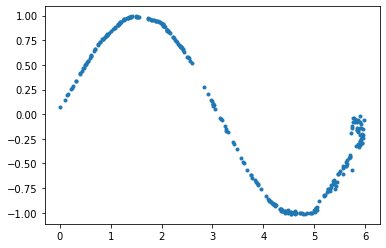

In [19]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")